In [1]:
# data comes from http://web.stanford.edu/~ericyi/project_page/part_annotation/index.html
from pyntcloud import PyntCloud
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np

import sys
import os
if sys.platform == 'darwin':
    data_path = os.getcwd() + "/PartAnnotation"
else:
    data_path = os.getcwd() + "\\PartAnnotation"

# Load model

In [2]:
def get_all_var_names():
    all_vars = []
    for i in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
        all_vars.append(i.name)
    return all_vars

def get_all_placeholders():
    return [x for x in tf.get_default_graph().get_operations() if x.type == "Placeholder"]

def get_all_mean_op():
    return [x for x in tf.get_default_graph().get_operations() if x.type == "Mean"]

def remove_var(var_name, var_set, mode='full_match'):
    """
    mode:
        'full_match'
        'startswith'
    """
    if mode == 'full_match':
        if var_name in var_set:
            var_set.remove(var_name)
    elif mode == 'startswith':
        for idx, val in enumerate(var_set):
            if val.startswith(var_name):
                var_set.remove(val)
    else:
        print('Mode not exists')

In [3]:
new_graph = tf.Graph()
config = tf.ConfigProto(allow_soft_placement=True) # allow passing gpu-trained model to a cpu machine
with tf.Session(graph=new_graph, config=config) as sess:

    import os
    model_fqn = os.path.join(os.getcwd(), 'trained_model', "model-2")
    saver = tf.train.import_meta_graph(model_fqn + ".meta")
    saver.restore(sess, model_fqn)

    graph = tf.get_default_graph()
    print(get_all_var_names())
    print("\nOptimizer", graph.get_collection("optimizer"))
    print("\nPlaceholders", get_all_placeholders())
    print("\nMean", get_all_mean_op())
    previous_vars = {var.op.name for var in tf.global_variables()}
#     previous_vars = [var_name for var_name, _ in tf.contrib.framework.list_variables('ckpt')]
    print(previous_vars)

INFO:tensorflow:Restoring parameters from C:\Users\212606295\Desktop\3D-CNN\3d_pointcloud\trained_model\model-2
['conv1/kernel:0', 'conv1/bias:0', 'conv2/kernel:0', 'conv2/bias:0', 'conv4/kernel:0', 'conv4/bias:0', 'conv5/kernel:0', 'conv5/bias:0', 'conv7/kernel:0', 'conv7/bias:0', 'conv8/kernel:0', 'conv8/bias:0', 'bn/gamma:0', 'bn/beta:0', 'bn/moving_mean:0', 'bn/moving_variance:0', 'full_con/kernel:0', 'full_con/bias:0', 'y_pred/kernel:0', 'y_pred/bias:0', 'training/beta1_power:0', 'training/beta2_power:0', 'conv1/kernel/Adam:0', 'conv1/kernel/Adam_1:0', 'conv1/bias/Adam:0', 'conv1/bias/Adam_1:0', 'conv2/kernel/Adam:0', 'conv2/kernel/Adam_1:0', 'conv2/bias/Adam:0', 'conv2/bias/Adam_1:0', 'conv4/kernel/Adam:0', 'conv4/kernel/Adam_1:0', 'conv4/bias/Adam:0', 'conv4/bias/Adam_1:0', 'conv5/kernel/Adam:0', 'conv5/kernel/Adam_1:0', 'conv5/bias/Adam:0', 'conv5/bias/Adam_1:0', 'conv7/kernel/Adam:0', 'conv7/kernel/Adam_1:0', 'conv7/bias/Adam:0', 'conv7/bias/Adam_1:0', 'conv8/kernel/Adam:0', '

In [4]:
def voxelize3D(pts, dim=[1,1,1]):
    """
    pts: receives .pts cloud point data. 2D array, arbitary sized X,Y,Z pairs. (We will only take x,y,z into account for now)
    dim: dimensioin of output voxelized data
    
    This function will locate the grid cube and calculate the density of each cube.
    The output will be normalized values.
    """
    assert(pts.shape[1]>=3), "pts file should contain at least x,y,z coordinate"
    assert(len(dim)==3), "Please provide 3-d grid size like [32,32,32]"
    
    # move all the axis to positive area.
    minimum_val = [pts[0][0], pts[0][1], pts[0][2]]

    # find the smallest 
    for pair in pts:
        if pair[0] < minimum_val[0]:
            minimum_val[0] = pair[0]
        if pair[1] < minimum_val[1]:
            minimum_val[1] = pair[1]
        if pair[2] < minimum_val[2]:
            minimum_val[2] = pair[2]
            
    # move it to first quadrant 
    rectified_pts = np.empty(pts.shape)
    for index, pair in enumerate(pts):
        point = np.zeros(3)
        point[0] = pair[0] - minimum_val[0]
        point[1] = pair[1] - minimum_val[1]
        point[2] = pair[2] - minimum_val[2]
        rectified_pts[index] = point
    
    # biggest value in each axis 
    maximum_val = pts[0][0]
    
    for pair in rectified_pts:
        for val in pair:
            if val > maximum_val:
                maximum_val = val
     
    # normalize all the axises to (0,1)
    normalized_pts = rectified_pts/maximum_val
    
    x_grid_length = 1/dim[0]
    y_grid_length = 1/dim[1]
    z_grid_length = 1/dim[2]
    
    output = np.zeros((dim[0],dim[1],dim[2]))
    
    epsilon = 0.000000000001 # we will have at least a 1.0 value which will exceed the index of grid
    # we can use a relativly small value to escape that to fit our data
    
    max_volume_size = 0
    
    for pair in normalized_pts:
        x_loc = int(pair[0]/(x_grid_length + epsilon))
        y_loc = int(pair[1]/(y_grid_length + epsilon))
        z_loc = int(pair[2]/(z_grid_length + epsilon))
        if output[x_loc, y_loc, z_loc] is None:
            output[x_loc, y_loc, z_loc] = 1
        else:
            output[x_loc, y_loc, z_loc] += 1
        
        if output[x_loc, y_loc, z_loc] > max_volume_size:
            max_volume_size = output[x_loc, y_loc, z_loc]
    
    output = output/max_volume_size    
            
    return output

In [5]:
def get_data(data_path, max_file_num=None, dim=[32,32,32]):
    data = []
    
    target_dir_path = os.path.join(data_path, 'points')
    path, dirs, files = os.walk(target_dir_path).__next__()
    file_count = len(files)
    
    count = 0
    for pts_data in os.scandir(target_dir_path):
        if (max_file_num is None) or (count < max_file_num):
            _path = os.path.join(data_path, 'points', pts_data.name)
            pts = PyntCloud.from_file(_path, sep=" ", header=0, names=["x","y","z"])
            _vox = voxelize3D(pts.xyz, dim=dim)
            vox_chan = np.array(_vox).reshape(_vox.shape + (1,))
            data.append(vox_chan)
            count += 1
        else:
            break
                
    return data

In [6]:
def get_previous_vars(model_path):
    
    new_graph = tf.Graph()
    config = tf.ConfigProto(allow_soft_placement=True) # allow passing gpu-trained model to a cpu machine
    
    with tf.Session(graph=new_graph, config=config) as sess:
        
        # Restore model
        previous_vars = {var.op.name for var in tf.global_variables()}

    return previous_vars

In [7]:
import h5py
import os
h5_data = h5py.File(os.path.join(os.getcwd(), 'small_dataset_with_background.h5'), mode='r')

data = h5_data.get("voxels")
label = h5_data.get("labels")
label_ref = h5_data.get("label_ref")

print(data.shape, label.shape, label_ref.value)

(3543, 32, 32, 32, 1) (3543, 13) [b'pistol' b'pipes' b'rocket' b'knife' b'motorbike' b'mug' b'laptop'
 b'skateboar' b'backgroun' b'guitar' b'earphone' b'bag' b'cap']


In [8]:
import tensorflow as tf
def cnn3d_model(x_train_data, label_size, stop_layer=0, keep_rate=0.7, seed=None):
    
    if seed is not None:
        tf.set_random_seed(seed)
        
    stop_config = np.ones(14, dtype=bool)
    for _ in range(stop_layer):
        stop_config[_] = False
    
    with tf.name_scope("layer_a"):
        # conv => 32*32*32
        conv1 = tf.layers.conv3d(inputs=x_train_data, filters=16, kernel_size=[3,3,3], padding='same',trainable=bool(stop_config[1]), activation=tf.nn.relu, name="conv1", reuse=tf.AUTO_REUSE)
        # conv => 32*32*32
        conv2 = tf.layers.conv3d(inputs=conv1, filters=32, kernel_size=[3,3,3], padding='same',trainable=bool(stop_config[2]), activation=tf.nn.relu, name="conv2", reuse=tf.AUTO_REUSE)
        # pool => 16*16*16
        pool3 = tf.layers.max_pooling3d(inputs=conv2, pool_size=[2, 2, 2], strides=2, name="pool3")
        
    with tf.name_scope("layer_b"):
        # conv => 16*16*16
        conv4 = tf.layers.conv3d(inputs=pool3, filters=64, kernel_size=[3,3,3], padding='same',trainable=bool(stop_config[4]), activation=tf.nn.relu, name="conv4", reuse=tf.AUTO_REUSE)
        # conv => 16*16*16
        conv5 = tf.layers.conv3d(inputs=conv4, filters=128, kernel_size=[3,3,3], padding='same',trainable=bool(stop_config[5]), activation=tf.nn.relu, name="conv5", reuse=tf.AUTO_REUSE)
        # pool => 8*8*8
        pool6 = tf.layers.max_pooling3d(inputs=conv5, pool_size=[2, 2, 2], strides=2, name="pool6")
        
    with tf.name_scope("layer_c"):
        # conv => 8*8*8
        conv7 = tf.layers.conv3d(inputs=pool6, filters=256, kernel_size=[3,3,3], padding='same',trainable=bool(stop_config[7]), activation=tf.nn.relu, name="conv7", reuse=tf.AUTO_REUSE)
        # conv => 8*8*8
        conv8 = tf.layers.conv3d(inputs=conv7, filters=512, kernel_size=[3,3,3], padding='same',trainable=bool(stop_config[8]), activation=tf.nn.relu, name="conv8", reuse=tf.AUTO_REUSE)
        # pool => 4*4*4
        pool9 = tf.layers.max_pooling3d(inputs=conv8, pool_size=[2, 2, 2], strides=2, name="pool9")
        
    with tf.name_scope("batch_norm"):
        cnn3d_bn = tf.layers.batch_normalization(inputs=pool9, trainable=bool(stop_config[10]), name="bn", reuse=tf.AUTO_REUSE)
        
    with tf.name_scope("fully_con"):
        flattening = tf.reshape(cnn3d_bn, [-1, 4*4*4*512])
        dense = tf.layers.dense(inputs=flattening, units=1024, activation=tf.nn.relu, trainable=bool(stop_config[11]), name="full_con", reuse=tf.AUTO_REUSE)
        # (1-keep_rate) is the probability that the node will be kept
        # training & trainable are different logic
        dropout = tf.layers.dropout(inputs=dense, rate=keep_rate, training=bool(stop_config[12]), name="dropout")
        
    with tf.name_scope("y_conv"):
        y_conv = tf.layers.dense(inputs=dropout, units=label_size, name="y_pred", trainable=bool(stop_config[13]), reuse=tf.AUTO_REUSE)
    
    return y_conv

In [9]:
def _get_streaming_metrics(prediction,label,num_classes):

    with tf.name_scope("test"):
        # Convert (?, num_classes) into (num_classes) 1-D array
        label_n = tf.argmax(label, 1)
        prediction_n = tf.argmax(prediction, 1)
        # Compute a per-batch confusion
        batch_confusion = tf.confusion_matrix(label_n, prediction_n, num_classes=num_classes, name='batch_confusion')
        # Create an accumulator variable to hold the counts
        confusion = tf.Variable(tf.zeros([num_classes,num_classes], dtype=tf.int32), name='confusion')
        # Create the update op for doing a "+=" accumulation on the batch
        confusion_update = confusion.assign(confusion + batch_confusion )
        # Cast counts to float so tf.summary.image renormalizes to [0,255]
        confusion_image = tf.reshape(tf.cast(confusion, tf.float32), [1, num_classes, num_classes, 1])

        tf.summary.image('confusion',confusion_image)

    return confusion_update,confusion

In [10]:
def new_model(n_classes, stop_layer):
    with tf.name_scope('inputs'):
        x_input = tf.placeholder(tf.float32, shape=[None, 32, 32, 32, 1], name="x_input")
        y_input = tf.placeholder(tf.float32, shape=[None, n_classes], name="y_input") 

    prediction = cnn3d_model(x_input, n_classes, seed=1234, stop_layer=stop_layer, keep_rate=0.5)
    tf.add_to_collection("logits", prediction)

    with tf.name_scope("cross_entropy"):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y_input), name="cross_entropy")

    with tf.name_scope("training"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
        tf.add_to_collection("optimizer", optimizer)

    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_input, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="acc")

    return {'prediction': prediction, 'cost': cost, 'optimizer': optimizer, 'correct': correct, 'accuracy': accuracy, 'x_input': x_input, 'y_input': y_input}

In [11]:
def remove_layers_from_trained_model(valid_vars, model_path):
    previous_vars = get_previous_vars(model_path)
    temp = list(previous_vars)[:]
    for idx, val in enumerate(valid_vars):
        remove_var(val, temp, mode='startswith')
    
    for idx, val in enumerate(temp):
        remove_var(val, previous_vars, mode='full_match')
        
    return previous_vars

In [22]:
import os
model_path = os.path.join(os.getcwd(), 'trained_model', 'model-2')

layers = ['conv1', 'conv2', 'pool3', 'conv4', 'conv5', 'pool6', 'conv7', 'conv8', 'pool9', 'bn', 'full_con', 'dropout', 'y_pred']

learning_rate = 0.0005
keep_rate = 0.5
batch_size = 16

x_ = data[:]
y_ = label[:]
print(x_.shape, y_.shape)
        
split_point = int(0.7*len(x_))
x_train = x_[:split_point]
y_train = y_[:split_point]

x_test = x_[split_point:]
y_test = y_[split_point:]

n_classes = len(y_train[0])

device_name = '/gpu:1' 

for stop_layer in range(14):
    with tf.Session(graph=tf.Graph(), config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        with tf.device(device_name):
            model = new_model(n_classes, stop_layer)

        confusion_update, confusion = _get_streaming_metrics(model['prediction'],model['y_input'],n_classes)
        
        tf.summary.scalar("cross_entropy", model['cost'])
        tf.summary.scalar("accuracy", model['accuracy'])
        summary_all = tf.summary.merge_all()

        logs_path = os.path.join(os.getcwd(), 'summaries', 'confusion_matrix3')
        #suffix
        filename_suffix = "_keep_rate_"+str(keep_rate)+"_batch_sizes_"+str(batch_size)+"_learning_rates_"+str(learning_rate)+"_stop_layer_"+str(stop_layer)
        train_writer = tf.summary.FileWriter(os.path.join(logs_path, 'train'), graph=tf.get_default_graph(), filename_suffix=filename_suffix)
        test_writer = tf.summary.FileWriter(os.path.join(logs_path, 'test'), graph=tf.get_default_graph(), filename_suffix=filename_suffix)
        summary_op = {'summary': summary_all, 'train_writer': train_writer, 'test_writer': test_writer}

        valid_vars = layers[:stop_layer]

        restore_vars = remove_layers_from_trained_model(valid_vars, model_path)

        restore_map = {variable.op.name : variable for variable in tf.global_variables() if variable.op.name in restore_vars}
        print(restore_map)
        tf.contrib.framework.init_from_checkpoint(os.path.join(os.getcwd(), 'trained_model', 'model-2'), restore_map)

        sess.run(tf.global_variables_initializer())

        print(tf.trainable_variables())

        graph = tf.get_default_graph()
        
        import math
        iterations_all = math.ceil(len(x_)/batch_size)
        iterations_train = math.ceil(len(x_train)/batch_size)
        iterations_test= math.ceil(len(x_test)/batch_size)

        for epoch in range(8):
            for itr in range(iterations_train):
                mini_batch_x = x_train[itr*batch_size: (itr+1)*batch_size]
                mini_batch_y = y_train[itr*batch_size: (itr+1)*batch_size]
                _optimizer, _cost, _acc, _summary = sess.run([model['optimizer'], model['cost'], model['accuracy'], summary_op['summary']], feed_dict={model['x_input']: mini_batch_x, model['y_input']: mini_batch_y})
                print('\tLost for', itr+1, "/", iterations_train, _cost, end='\r')

                summary_op['train_writer'].add_summary(_summary, epoch*batch_size + itr)
                summary_op['train_writer'].flush()
                
            print('\n')

            acc = 0
            for itr in range(iterations_test):
                mini_batch_x = x_test[itr*batch_size: (itr+1)*batch_size]
                mini_batch_y = y_test[itr*batch_size: (itr+1)*batch_size]
                _acc = sess.run(model['accuracy'], feed_dict={model['x_input']: mini_batch_x, model['y_input']: mini_batch_y})
                acc += _acc
                print('\tLost for', itr+1, "/", iterations_test, end='\r')

            summary = tf.Summary()
            summary.value.add(tag="Accuracy", simple_value=acc)
            summary_op['test_writer'].add_summary(summary, epoch)
            summary_op['test_writer'].flush()
            print('\n')
            print('Test Acc:', acc/iterations_test)
            
        for itr in range(iterations_test):
            mini_batch_x = x_test[itr*batch_size: (itr+1)*batch_size]
            mini_batch_y = y_test[itr*batch_size: (itr+1)*batch_size]
            _conf = sess.run(confusion_update, feed_dict={model['x_input']: mini_batch_x, model['y_input']: mini_batch_y})
        print(confusion.eval()) 
        
        summary_op['train_writer'].close()
        summary_op['test_writer'].close()

(3543, 32, 32, 32, 1) (3543, 13)
{}
[<tf.Variable 'conv1/kernel:0' shape=(3, 3, 3, 1, 16) dtype=float32_ref>, <tf.Variable 'conv1/bias:0' shape=(16,) dtype=float32_ref>, <tf.Variable 'conv2/kernel:0' shape=(3, 3, 3, 16, 32) dtype=float32_ref>, <tf.Variable 'conv2/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv4/kernel:0' shape=(3, 3, 3, 32, 64) dtype=float32_ref>, <tf.Variable 'conv4/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv5/kernel:0' shape=(3, 3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'conv5/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'conv7/kernel:0' shape=(3, 3, 3, 128, 256) dtype=float32_ref>, <tf.Variable 'conv7/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'conv8/kernel:0' shape=(3, 3, 3, 256, 512) dtype=float32_ref>, <tf.Variable 'conv8/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'bn/gamma:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'bn/beta:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'full_con/kernel:0' sh

	Lost for 155 / 155 0.1725299

	Lost for 67 / 67

Test Acc: 0.895255863667
	Lost for 155 / 155 0.0194202

	Lost for 67 / 67

Test Acc: 0.926039445756
	Lost for 155 / 155 0.0185685

	Lost for 67 / 67

Test Acc: 0.930970149254
	Lost for 155 / 155 0.01216471

	Lost for 67 / 67

Test Acc: 0.9375
	Lost for 155 / 155 0.00983221

	Lost for 67 / 67

Test Acc: 0.935634328358
	Lost for 155 / 155 0.01900679

	Lost for 67 / 67

Test Acc: 0.933768656716
	Lost for 155 / 155 0.00184199

	Lost for 67 / 67

Test Acc: 0.9375
	Lost for 155 / 155 0.01331569

	Lost for 67 / 67

Test Acc: 0.940298507463
[[ 97   1   0   0   1   0   0   0   0   0   0   0   0]
 [  0  96   0   0   0   0   0   0   2   0   0   0   0]
 [  2   0  17   0   1   1   0   1   4   0   0   0   0]
 [  0   0   0 120   0   0   0   0   0   3   0   0   0]
 [  0   0   0   0  96   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0  66   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 143   0   0   0   0   0   0]
 [  0   0   0   0   0   0 

	Lost for 155 / 155 0.0391148

	Lost for 67 / 67

Test Acc: 0.895255863667
	Lost for 155 / 155 0.0188741

	Lost for 67 / 67

Test Acc: 0.911114072622
	Lost for 155 / 155 0.0865393

	Lost for 67 / 67

Test Acc: 0.926305970149
	Lost for 155 / 155 0.0221642

	Lost for 67 / 67

Test Acc: 0.934701492537
	Lost for 155 / 155 0.05761026

	Lost for 67 / 67

Test Acc: 0.922574626866
	Lost for 155 / 155 0.03220549

	Lost for 67 / 67

Test Acc: 0.929104477612
	Lost for 155 / 155 0.01808676

	Lost for 67 / 67

Test Acc: 0.92723880597
	Lost for 155 / 155 0.02155721

	Lost for 67 / 67

Test Acc: 0.934701492537
[[ 98   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0  94   0   0   0   0   0   0   4   0   0   0   0]
 [  3   0  16   0   1   0   0   2   4   0   0   0   0]
 [  0   0   0 115   0   0   0   0   0   8   0   0   0]
 [  1   0   0   0  96   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  66   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 143   0   0   0   0   0   0]
 [  0   0   

{}
[<tf.Variable 'full_con/kernel:0' shape=(32768, 1024) dtype=float32_ref>, <tf.Variable 'full_con/bias:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'y_pred/kernel:0' shape=(1024, 13) dtype=float32_ref>, <tf.Variable 'y_pred/bias:0' shape=(13,) dtype=float32_ref>, <tf.Variable 'test/confusion:0' shape=(13, 13) dtype=int32_ref>]
	Lost for 155 / 155 0.272093 155 2.09445 / 155 1.6993539 / 155 1.30792 / 155 1.2319/ 155 1.06878 / 155 1.00027 / 155 0.865093 / 155 0.517461 / 155 0.476442 / 155 0.542273/ 155 0.366507

	Lost for 67 / 67

Test Acc: 0.867004264647
	Lost for 155 / 155 0.140182155 0.97313 155 0.649597 / 155 0.649144 / 155 0.390012 / 155 0.624349 / 155 0.92289259 / 155 0.36558 / 155 0.419842 63 / 155 0.646949 / 155 0.79768568 / 155 0.562411 / 155 0.153873 / 155 0.32003 / 155 0.338967/ 155 0.33321 / 155 0.286327/ 155 0.885037 / 155 0.141904/ 155 0.179526 / 155 0.325389/ 155 0.621547 / 155 0.298179 / 155 0.664389/ 155 0.323026 / 155 0.986682 / 155 0.865061 112 / 155 0.823985 / 1

In [26]:
label_ref.value

array([b'laptop', b'motorbike', b'pipes', b'knife', b'mug', b'pistol',
       b'guitar', b'skateboar', b'rocket', b'cap', b'earphone', b'bag'],
      dtype='|S9')

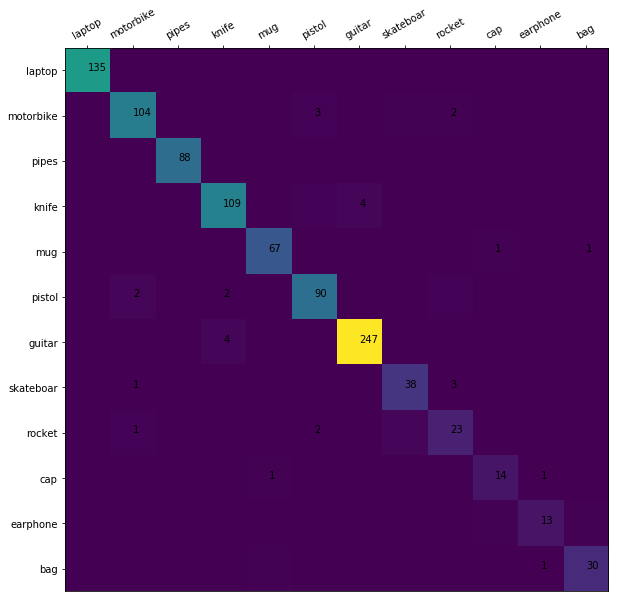

In [49]:
cm = [[135,   0,   0 ,  0,   0,   0,   0,   0,   0,   0,   0,   0],
 [  0, 104,   0,   0,   0,   2,   0,   1,   1,   0,   0,   0],
 [  0,   0,  88,   0,   0,   0,   0,   0,   0,   0,   0,   0],
 [  0,   0,   0, 109,   0,   2,   4,   0,   0,   0,   0,   0],
 [  0,   0,   0,   0,  67,   0,   0,   0,   0,   1,   0,   0],
 [  0,   3,   0,   0,   0,  90,   0,   0,   2,   0,   0,   0],
 [  0,   0,   0,   4,   0,   0, 247,   0,   0,   0,   0,   0],
 [  0,   0,   0,   0,   0,   0,   0,  38,   0,   0,   0,   0],
 [  0,   2,   0,   0,   0,   0,   0,   3,  23,   0,   0,   0],
 [  0,   0,   0,   0,   1,   0,   0,   0,   0,  14,   0,   0],
 [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  13,   1],
 [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,  30]]

tags = ['laptop', 'motorbike', 'pipes', 'knife', 'mug', 'pistol', 'guitar', 'skateboar', 'rocket', 'cap', 'earphone', 'bag']

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10,10))

ax.xaxis.set_ticks_position('top')
plt.imshow(cm, interpolation='nearest')
plt.xticks(np.arange(0,12), tags, rotation=30)
plt.yticks(np.arange(0,12), tags)

for i,j in ((x,y) for x in range(len(cm))
            for y in range(len(cm[0]))):
    if cm[i][j] is not 0:
        ax.annotate(str(cm[i][j]),xy=(i,j))

plt.show()

# Plot

In [268]:
# %load ./voxel_grid_plot.py
import os
import shutil

import numpy as np

from IPython.display import IFrame
from matplotlib import pyplot as plt


def plot_voxelgrid(voxelgrid,
                   output_name=None,
                   cmap="Oranges",
                   axis=True,
                   width=800,
                   height=600):

    scaled_shape = voxelgrid.shape

    vector = voxelgrid
    points = np.argwhere(vector) * scaled_shape

    s_m = plt.cm.ScalarMappable(cmap=cmap)
    rgb = s_m.to_rgba(vector.reshape(-1)[vector.reshape(-1) > 0])

    camera_position = points.max(0) + abs(points.max(0))

    look = points.mean(0)

    if axis:
        axis_size = points.ptp() * 1.5
    else:
        axis_size = 0

    placeholders = {}

    placeholders["POINTS_X_PLACEHOLDER"] = points[:, 0].tolist()
    placeholders["POINTS_Y_PLACEHOLDER"] = points[:, 1].tolist()
    placeholders["POINTS_Z_PLACEHOLDER"] = points[:, 2].tolist()

    placeholders["R_PLACEHOLDER"] = rgb[:, 0].tolist()
    placeholders["G_PLACEHOLDER"] = rgb[:, 1].tolist()
    placeholders["B_PLACEHOLDER"] = rgb[:, 2].tolist()

    placeholders["S_x_PLACEHOLDER"] = scaled_shape[0]
    placeholders["S_y_PLACEHOLDER"] = scaled_shape[1]
    placeholders["S_z_PLACEHOLDER"] = scaled_shape[2]

    placeholders["CAMERA_X_PLACEHOLDER"] = camera_position[0]
    placeholders["CAMERA_Y_PLACEHOLDER"] = camera_position[1]
    placeholders["CAMERA_Z_PLACEHOLDER"] = camera_position[2]

    placeholders["LOOK_X_PLACEHOLDER"] = look[0]
    placeholders["LOOK_Y_PLACEHOLDER"] = look[1]
    placeholders["LOOK_Z_PLACEHOLDER"] = look[2]

    placeholders["AXIS_SIZE_PLACEHOLDER"] = axis_size

    placeholders["N_VOXELS_PLACEHOLDER"] = sum(vector.reshape(-1) > 0)

    if output_name is None:
        output_name = "plotVG.html"

    BASE_PATH = os.getcwd()
    src = "{}/{}".format(BASE_PATH, "voxelgrid.html")
    dst = "{}/{}".format(os.getcwd(), output_name)

    with open(src, "r") as inp, open(dst, "w") as out:
        for line in inp:
            for key, val in placeholders.items():
                if key in line:
                    line = line.replace(key, str(val))
            out.write(line)

    return IFrame(output_name, width=width, height=height)

# Feature extraction

In [11]:
# one hot indexes
# 2: chair , 3: car

import os
model_path = os.path.join(os.getcwd(), 'trained_model', 'model-4')

params = get_model_params(model_path)

print(params['conv1_w'].shape)

INFO:tensorflow:Restoring parameters from /Users/shijian/git/3D-CNN/3d_pointcloud/trained_model/model-4
(3, 3, 3, 1, 16)


In [12]:
file_num =7000

a = get_data(data_path + "/airplane", max_file_num=file_num)

In [380]:
def do_padding(target, kernel, stride, padding='SAME'):
    # Algorithm comes from https://github.com/tensorflow/tensorflow/commit/a276e0999ab4223ac36d75221028d3e8835c60ae
    size, kernelsize, color_channels = get_shapes(target, kernel)
    
    import math
    if padding is 'SAME':
        out_width = math.ceil(float(size) / float(stride))
        pad_along_width = max((out_width - 1) * stride + kernelsize - size, 0)
        pad_left_and_top = pad_along_width // 2
        pad_right_and_bottom = pad_along_width - pad_left_and_top
        padded_target = zero_padding_3d(target, (int((pad_left_and_top)), int(pad_right_and_bottom)))
        
    elif padding is 'VALID':
        # no padding would be used
        out_width = math.floor(float(size - kernelsize) / float(stride) + 1)
        border = (out_width-1)*stride + kernelsize
        print(out_width, border)
        padded_target = target[:border,:border,:border, :]
        
    else:
        raise TypeError('Padding strategy `' + padding + '` not found.')
        
    print("Padded shape", padded_target.shape)
    return padded_target


def zero_padding_3d(target, padding=None):
    if padding is not None:
        target = np.pad(target, [(padding[0], padding[1]), (padding[0], padding[1]), (padding[0], padding[1]), (0,0)], mode='constant')
    return target


def single_convolve_3d(padded_target_slice, kernel):
    _slice = padded_target_slice * kernel
    res = np.sum(np.sum(np.sum(np.sum(_slice, axis=0), axis=0),axis=0), axis=0)
    return res


def convole_3d(padded_target, kernel, kernel_bias, stride):
    
    size, kernelsize, color_channels = get_shapes(padded_target, kernel)
    outsize = get_outsize(size, kernelsize, stride)
    filter_num = num_of_filters(kernel)
    
    res = np.zeros((outsize, outsize, outsize, filter_num))
    
    for i in range(outsize):
        for j in range(outsize):
            for k in range(outsize):
                for f in range(filter_num):
                    i_start = i * stride
                    j_start = j * stride
                    k_start = k * stride

                    padded_target_slice = padded_target[i_start : i_start+kernelsize, j_start : j_start+kernelsize, k_start : k_start+kernelsize, :]
                    res[i_start, j_start, k_start, f] = single_convolve_3d(padded_target_slice, kernel[:,:,:,:,f])
                    
    print(res.shape)
    return res + kernel_bias
   
def max_pool_slice(target_slice):
    return np.max(target_slice)

def get_shapes(target, kernel):
    size = target.shape[0]
    color_channels = target.shape[3]
    kernelsize = kernel.shape[0]
    assert(color_channels == kernel.shape[3]), "The shape of kernel and input does not match, it must have same number of channels."
    return size, kernelsize, color_channels

def get_outsize(size, kernelsize, stride):
    outsize = (size-kernelsize)/stride + 1
    assert(outsize == int(outsize)), "Number of filters must be integer"
    
    return int(outsize)

def num_of_filters(kernel):
    return kernel.shape[4]

In [381]:
def output_features(target, kernel, bias=None, stride=1, padding='SAME'):
    
    size, kernelsize, color_channels = get_shapes(target, kernel)
    outsize = get_outsize(size, kernelsize, stride)
    filter_num = num_of_filters(kernel)
    
    padded_target = do_padding(target, kernel, stride)
    output = convole_3d(padded_target, kernel, bias, stride)
    
    print(output.shape)
    return output


def max_pooling(target, pool_size=2, stride=2):
    
    size = target.shape[0]
    outsize = get_outsize(size, pool_size, stride)
    filter_num = target.shape[3]
    
    output = np.zeros((outsize, outsize, outsize, filter_num))
    for i in range(outsize):
        for j in range(outsize):
            for k in range(outsize):
                for f in range(filter_num):
                    i_start = i*stride
                    j_start = j*stride
                    k_start = k*stride
                    
                    output[i, j, k, f] = max_pool_slice(target[i_start:i_start+2, j_start:j_start+2, k_start:k_start+2, f])
                    
    return output


In [331]:
first_conv = output_features(a[0], params['conv1_w'], params['conv1_b'], stride=1, padding='SAME')
plot_voxelgrid(first_conv[:,:,:,1])

Padded shape (34, 34, 34, 1)
(32, 32, 32, 16)
(32, 32, 32, 16)


In [333]:
second_conv = output_features(first_conv, params['conv2_w'], params['conv2_b'], stride=1, padding='SAME')
plot_voxelgrid(second_conv[:,:,:,1])

Padded shape (34, 34, 34, 16)
(32, 32, 32, 32)
(32, 32, 32, 32)


In [386]:
third_pool = max_pooling(second_conv, pool_size=2, stride=2)
plot_voxelgrid(third_pool[:,:,:,1])

In [398]:
forth_conv = output_features(third_pool, params['conv4_w'], params['conv4_b'], stride=1, padding='SAME')
fifth_conv = output_features(forth_conv, params['conv5_w'], params['conv5_b'], stride=1, padding='SAME')
sixth_pooling = max_pooling(fifth_conv, pool_size=2, stride=2)

Padded shape (18, 18, 18, 32)
(16, 16, 16, 64)
(16, 16, 16, 64)
Padded shape (18, 18, 18, 64)
(16, 16, 16, 128)
(16, 16, 16, 128)


In [397]:
plot_voxelgrid(sixth_pooling[:,:,:,10])

In [399]:
seventh_conv = output_features(sixth_pooling, params['conv7_w'], params['conv7_b'], stride=1, padding='SAME')
eighth_conv = output_features(seventh_conv, params['conv8_w'], params['conv8_b'], stride=1, padding='SAME')
ninth_pooling = max_pooling(eighth_conv, pool_size=2, stride=2)

Padded shape (10, 10, 10, 128)
(8, 8, 8, 256)
(8, 8, 8, 256)
Padded shape (10, 10, 10, 256)
(8, 8, 8, 512)
(8, 8, 8, 512)


In [ ]:
plot_voxelgrid(sixth_pooling[:,:,:,10])